In [1]:
from os import listdir

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy, Precision, Recall, F1Score

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as transforms

from tqdm import tqdm

import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

In [2]:
print("PyTorch Version:", torch.__version__)
print("TorchVision Version:", torchvision.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU with MPS backend.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

PyTorch Version: 2.7.0.dev20250224
TorchVision Version: 0.22.0.dev20250224
Using GPU with MPS backend.


#### Define train path

In [3]:
#convert to RGBA first because of error Projects/Fruit and veg/myenv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
#warnings.warn(

PATH =  "../RGBAKaggleData"
train_path = PATH + "/train"
test_path = PATH + "/test"
val_path = PATH + "/validation"
len(listdir(train_path))

36

#### Load dataset

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 32

train_dataset = datasets.ImageFolder(train_path, transform= transform)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True, num_workers=4)

test_dataset = datasets.ImageFolder(test_path, transform= transform)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= True, num_workers=4)

val_dataset = datasets.ImageFolder(val_path, transform= transform)
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle= True, num_workers=4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


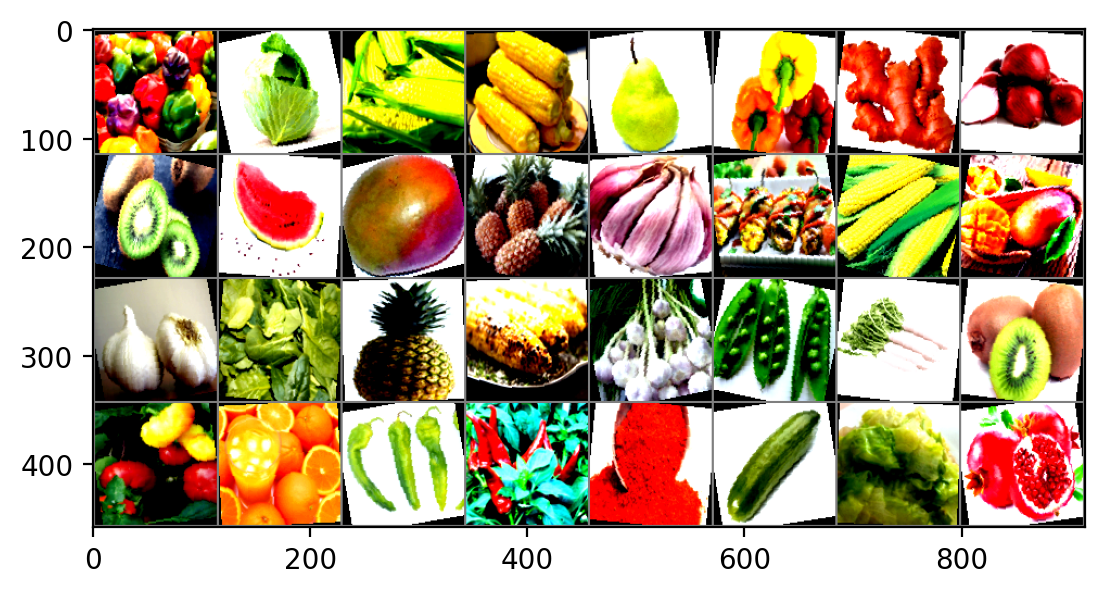

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

#### Define Neural Network


In [6]:
def get_fc_input_size():
    dummy_input = torch.randn(1, 3, 112, 112)  
    temp_net = NetBase()  # Use a temporary instance
    dummy_output = temp_net.pool(F.relu(temp_net.conv2(temp_net.pool(F.relu(temp_net.conv1(dummy_input))))))
    return dummy_output.numel()

class NetBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride = 1, padding = 1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, padding=1)

class Net(NetBase):
    def __init__(self):
        super().__init__()
        fc1_input_size = get_fc_input_size()  
        self.fc1 = nn.Linear(16* 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#### Define loss function and optimiser

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay = 1e-4)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) <- fantastic but takes too long.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience = 4, factor =0.5)

#### Train the model

In [ ]:
patience = 9
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []
total_iterations = len(train_dataloader)
for epoch in range(200):  
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total = total_iterations, ncols = 100, desc=f"Epoch {epoch+1}", leave =False):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    #print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}')

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            val_loss +=loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(net.state_dict(), 'best_model.pth')
    else:
        counter+=1   
        print(f"Early stopping counter:{epoch +1} - {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered: {epoch +1}")
            break

print('Finished Training')

Epoch 5:   0%|                                                               | 0/97 [00:00<?, ?it/s]

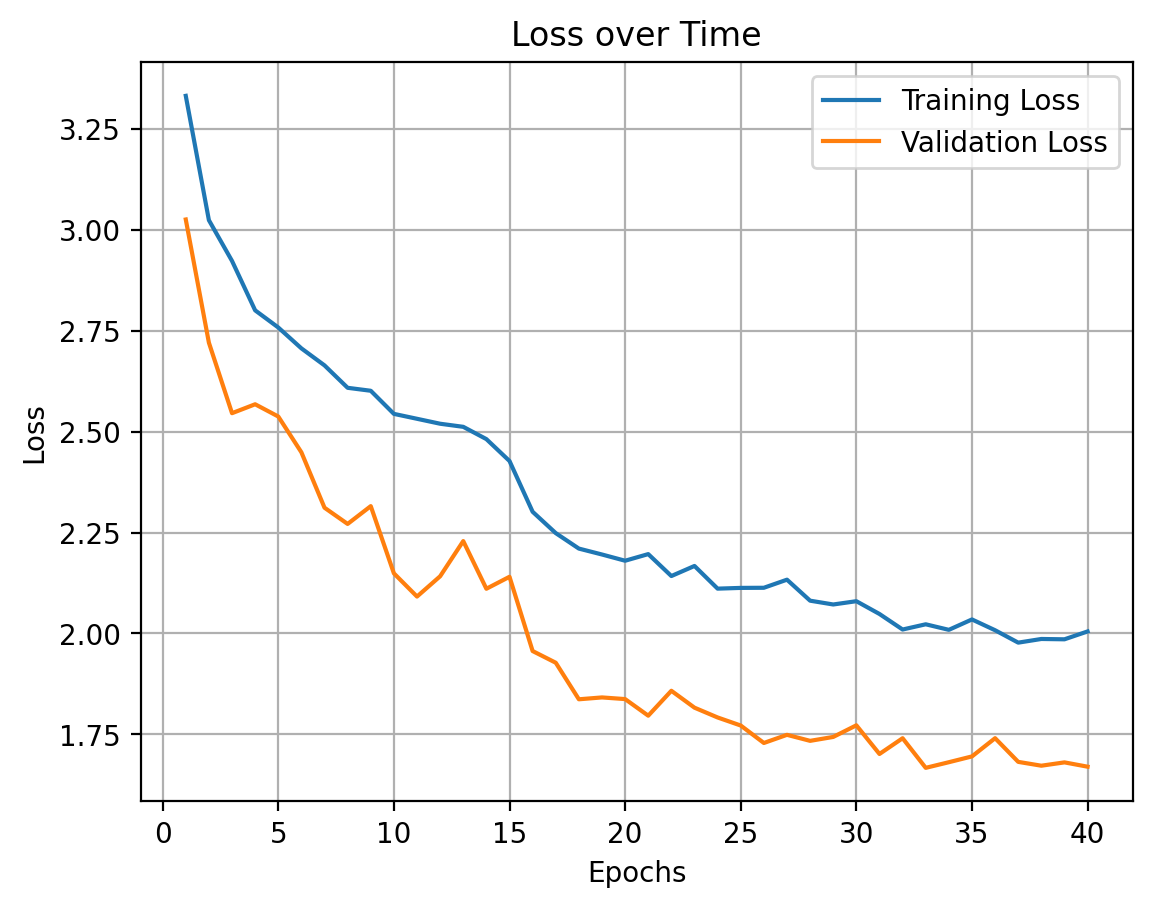

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(range(1, epoch+2), train_losses, label="Training Loss")
plt.plot(range(1, epoch+2), val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.grid(True)
plt.legend()
plt.show()
plt.savefig("../Results/LossEachEpoch.png", format='png')

## Test

In [ ]:
# Initialize metrics
accuracy = MulticlassAccuracy(num_classes=36)  
precision = Precision(num_classes=36, task="multiclass")
recall = Recall(num_classes=36, task="multiclass")
f1_score = F1Score(num_classes=36, task="multiclass")

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update metrics
        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

# Get the final metric values
print(f'Accuracy: {accuracy.compute() * 100:.2f}%')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'F1-Score: {f1_score.compute()}')

/Users/adenrelekomolafe/Documents/Personal Projects/Fruit and veg/myenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:682: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 50.34%
Precision: 0.5041782855987549
Recall: 0.5041782855987549
F1-Score: 0.5041782855987549


In [ ]:
all_preds = []
all_labels = []
classes = test_dataloader.dataset.classes

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print a detailed classification report
print(metrics.classification_report(all_labels, all_preds, target_names=classes))

               precision    recall  f1-score   support

        apple       0.67      0.40      0.50        10
       banana       0.60      0.33      0.43         9
     beetroot       0.67      0.80      0.73        10
  bell pepper       0.50      0.40      0.44        10
      cabbage       0.80      0.40      0.53        10
     capsicum       0.67      0.40      0.50        10
       carrot       0.33      0.30      0.32        10
  cauliflower       0.62      0.80      0.70        10
chilli pepper       0.15      0.20      0.17        10
         corn       0.25      0.10      0.14        10
     cucumber       0.60      0.30      0.40        10
     eggplant       0.90      0.90      0.90        10
       garlic       1.00      0.90      0.95        10
       ginger       0.22      0.20      0.21        10
       grapes       0.88      0.70      0.78        10
     jalepeno       0.50      0.40      0.44        10
         kiwi       0.50      0.80      0.62        10
        l

In [ ]:
print(classes)

## Validation

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update metrics
        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

# Get the final metric values
print(f'Accuracy: {accuracy.compute() * 100:.2f}%')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'F1-Score: {f1_score.compute()}')

/Users/adenrelekomolafe/Documents/Personal Projects/Fruit and veg/myenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:682: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 51.45%
Precision: 0.5154929757118225
Recall: 0.5154929757118225
F1-Score: 0.5154929757118225


In [ ]:
all_preds = []
all_labels = []
classes = val_dataloader.dataset.classes

with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print(metrics.classification_report(all_labels, all_preds, target_names=classes))

               precision    recall  f1-score   support

        apple       0.62      0.50      0.56        10
       banana       0.50      0.33      0.40         9
     beetroot       0.64      0.70      0.67        10
  bell pepper       0.40      0.44      0.42         9
      cabbage       1.00      0.60      0.75        10
     capsicum       0.67      0.40      0.50        10
       carrot       0.50      0.56      0.53         9
  cauliflower       0.75      0.60      0.67        10
chilli pepper       0.10      0.11      0.11         9
         corn       0.00      0.00      0.00        10
     cucumber       0.44      0.40      0.42        10
     eggplant       0.90      0.90      0.90        10
       garlic       0.78      0.70      0.74        10
       ginger       0.25      0.20      0.22        10
       grapes       0.88      0.78      0.82         9
     jalepeno       0.44      0.44      0.44         9
         kiwi       0.53      0.90      0.67        10
        l

/Users/adenrelekomolafe/Documents/Personal Projects/Fruit and veg/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adenrelekomolafe/Documents/Personal Projects/Fruit and veg/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adenrelekomolafe/Documents/Personal Projects/Fruit and veg/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

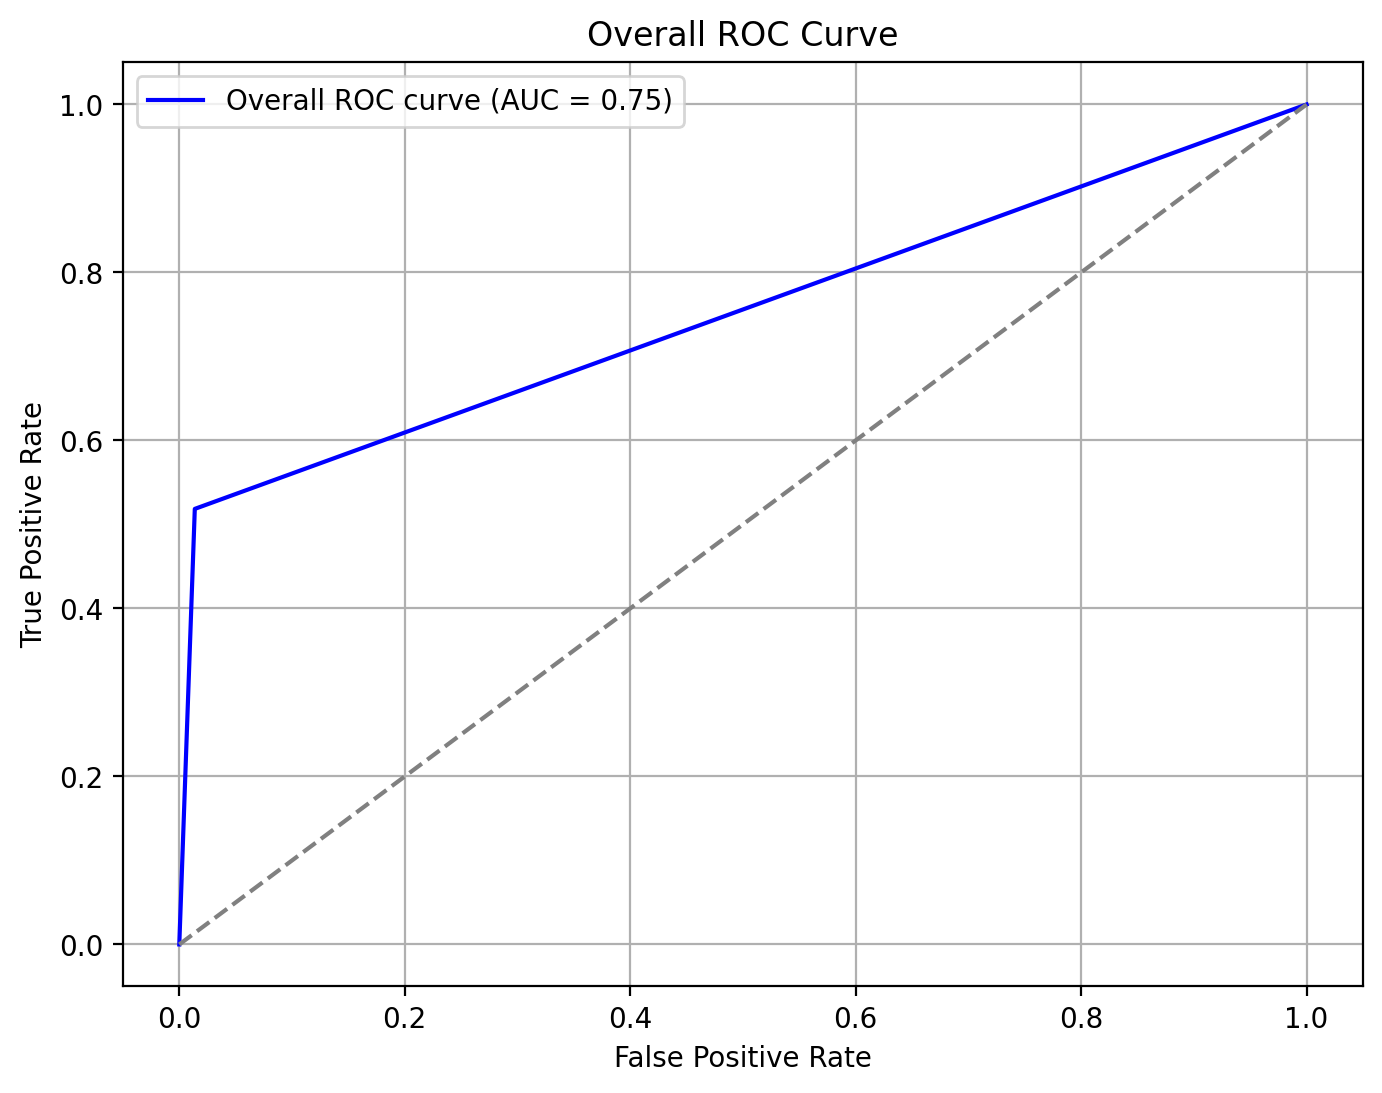

<Figure size 640x480 with 0 Axes>

In [ ]:
y_true_bin = label_binarize(all_labels, classes=range(len(classes)))
y_pred_bin = label_binarize(all_preds, classes=range(len(classes)))


fpr, tpr, _ = metrics.roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc = metrics.auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Overall ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve")
plt.legend()
plt.grid()
plt.show()
plt.savefig("../Results/RocCurve.png", format='png')

# Save Model

In [ ]:
model_file_name = "best_model.pth"
#torch.save(net.state_dict(),model_file_name)

source = model_file_name
destination = "../" + model_file_name

#copy model to the directory that can be used by the main.py file
with open(source, "rb") as src, open(destination, "wb") as dest:
    while chunk := src.read(4096):  
        dest.write(chunk)
